# Using lifelines to fit KM curves

References:<br>
  - https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html  # noqa

In [73]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from lifelines.datasets import load_waltons
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [74]:
from IPython.core.interactiveshell import InteractiveShell  # noqa

In [75]:
InteractiveShell.ast_node_interactivity = "all"

## Example 1

In [76]:
waltons = load_waltons()
waltons.columns = ["time", "event", "group"]
waltons.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
time,163,NaN,NaN,NaN,49.6135,17.078,6,41,56,61,75
event,163,NaN,NaN,NaN,0.957055,0.203357,0,1,1,1,1
group,163,2,control,129,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<lifelines.KaplanMeierFitter:"waltons_data", fitted with 163 total observations, 7 right-censored observations>

<AxesSubplot:xlabel='timeline'>

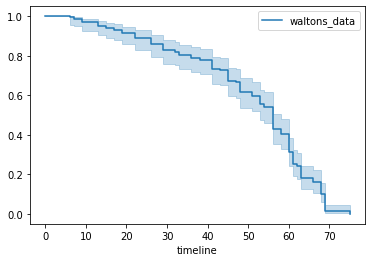

In [77]:
kmf = KaplanMeierFitter(label="waltons_data")
kmf.fit(waltons["time"], waltons["event"])
kmf.plot_survival_function()
plt.show()

## Smoothing the survival curve by using smoothed hazard function

Reference: [github link](https://github.com/nayefahmad/survival-analysis-notes/blob/main/src/2022-02-09_smoothing-the-km-estimate.md) # noqa

This is the `gastricXelox` data in R package `asaur`.

In [78]:
time_months = [
    0.9256198,
    1.8512397,
    1.8512397,
    1.8512397,
    2.0826446,
    2.5454545,
    2.7768595,
    3.0082645,
    3.7024793,
    3.7024793,
    3.9338843,
    3.9338843,
    4.3966942,
    4.8595041,
    5.5537190,
    5.5537190,
    5.7851240,
    6.4793388,
    6.4793388,
    6.9421488,
    8.5619835,
    8.5619835,
    9.7190083,
    9.9504132,
    9.9504132,
    10.6446281,
    11.1074380,
    11.5702479,
    11.8016529,
    12.2644628,
    12.4958678,
    13.1900826,
    13.6528926,
    13.6528926,
    13.8842975,
    14.8099174,
    15.2727273,
    17.5867769,
    18.0495868,
    21.0578512,
    27.5371901,
    27.7685950,
    32.1652893,
    40.7272727,
    43.2727273,
    46.9752066,
    50.2148760,
    58.5454545,
]

In [79]:
delta = [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
]

KM curve:

<lifelines.KaplanMeierFitter:"gastricXelox data", fitted with 48 total observations, 16 right-censored observations>

<AxesSubplot:xlabel='timeline'>

Text(0.5, 1.0, 'KM estimate of survival function')

c:\Nayef\survival-analysis-notes\.venv\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


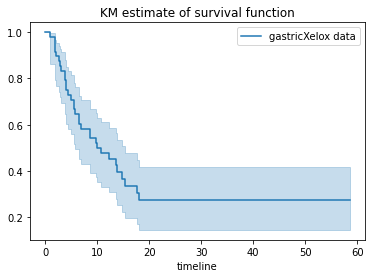

In [80]:
km2 = KaplanMeierFitter(label="gastricXelox data")
km2.fit(time_months, delta)
fig, ax = plt.subplots()
km2.plot_survival_function(ax=ax)
ax.set_title('KM estimate of survival function')
fig.show()

## Nelson-Aalen-based cumulative hazard function and smoothed hazard fn:

<lifelines.NelsonAalenFitter:"NA_estimate", fitted with 48 total observations, 16 right-censored observations>

<AxesSubplot:xlabel='timeline'>

Text(0.5, 1.0, 'Estimated cumulative hazard function')

c:\Nayef\survival-analysis-notes\.venv\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


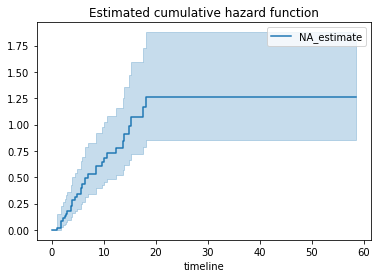

In [81]:
na1 = NelsonAalenFitter()
na1.fit(time_months, delta)
fig, ax = plt.subplots()
na1.plot_cumulative_hazard(ax=ax)
ax.set_title("Estimated cumulative hazard function")
fig.show()

<AxesSubplot:>

Text(0.5, 1.0, 'Estimated hazard function')

c:\Nayef\survival-analysis-notes\.venv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


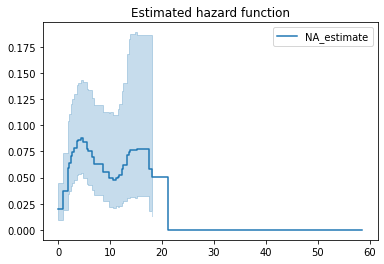

In [82]:
bandwidth = 3
fig, ax = plt.subplots()
na1.plot_hazard(bandwidth=bandwidth, ax=ax)
ax.set_title("Estimated hazard function")
fig.show()

Recover the data underlying the plot using the `smoothed_hazard_()` method

In [83]:
df_smoothed_hazard = (
    na1.smoothed_hazard_(bandwidth=bandwidth)
    .reset_index()
    .rename(
        columns={"index": "time", "differenced-NA_estimate": "hazard_estimate"}
    )  # noqa
)
df_smoothed_hazard.head()
df_smoothed_hazard.tail()

,time,hazard_estimate
0,0.000000,0.020236
1,0.925620,0.037579
2,1.851240,0.059442
3,2.082645,0.064217
4,2.545454,0.070805


,time,hazard_estimate
35,40.727273,0.0
36,43.272727,0.0
37,46.975207,0.0
38,50.214876,0.0
39,58.545454,0.0


In [84]:
n_haz = len(df_smoothed_hazard)
times_diff = df_smoothed_hazard["time"].diff()
times_diff = times_diff[1:].reset_index(drop=True)

In [85]:
hazards = df_smoothed_hazard["hazard_estimate"][0:-1]
assert len(hazards) == len(times_diff)

In [86]:
surv_smoothed = np.exp(-np.cumsum(hazards * times_diff))

todo: show km estimate on same graph<br>
df_surv_smoothed = pd.DataFrame({'time': time_months,<br>
                                 'surv_from_smoothed_hazard': surv_smoothed})

<AxesSubplot:>

(0.0, 1.0)

Text(0.5, 1.0, 'Estimated survival curve based on smoothed estimate of hazard function \nBandwidth=3')

c:\Nayef\survival-analysis-notes\.venv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


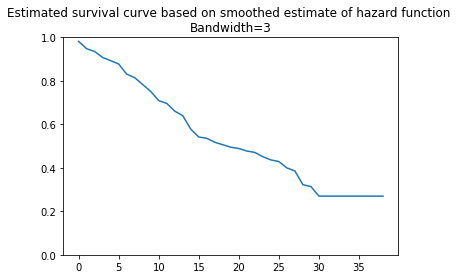

In [87]:
fig, ax = plt.subplots()
surv_smoothed.plot(ax=ax)
ax.set_ylim((0, 1))
ax.set_title(f'Estimated survival curve based on smoothed estimate of hazard function \nBandwidth={bandwidth}')
fig.show()

In [88]:
km2.survival_function_

,gastricXelox data
timeline,
0.000000,1.000000
0.925620,0.979167
1.851240,0.916667
2.082645,0.895833
2.545454,0.875000
2.776860,0.854167
3.008265,0.833333
3.702479,0.791667
3.933884,0.750000
